Dataset loaded successfully
Date columns converted successfully


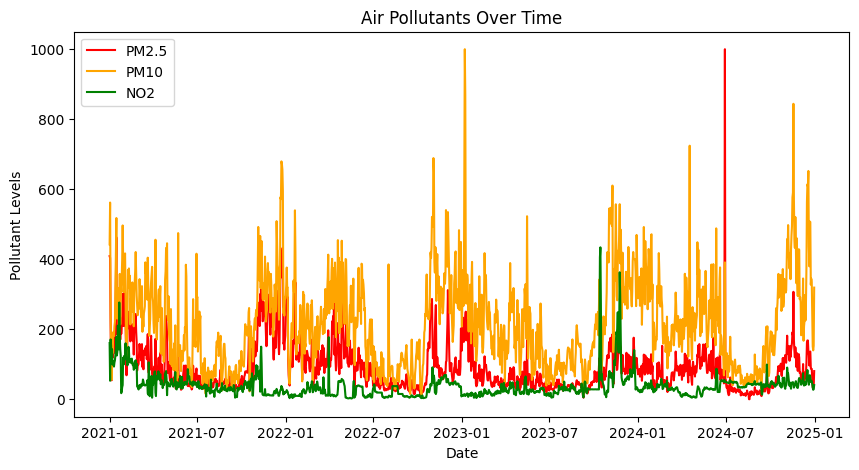

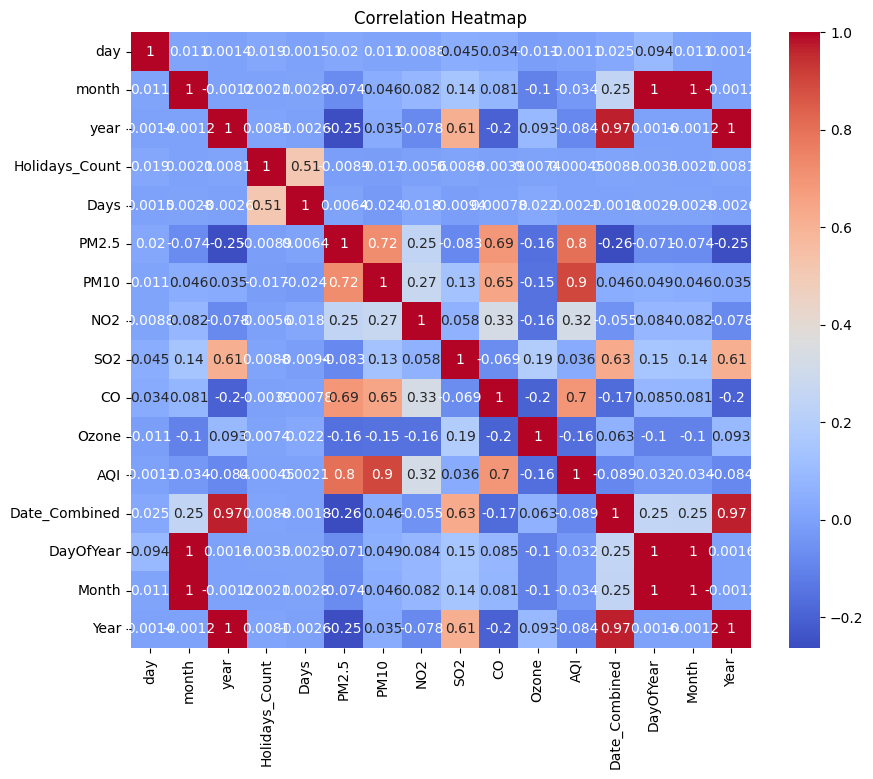

Training Score: 0.9878619751260107
Test Score: 0.936183909152957


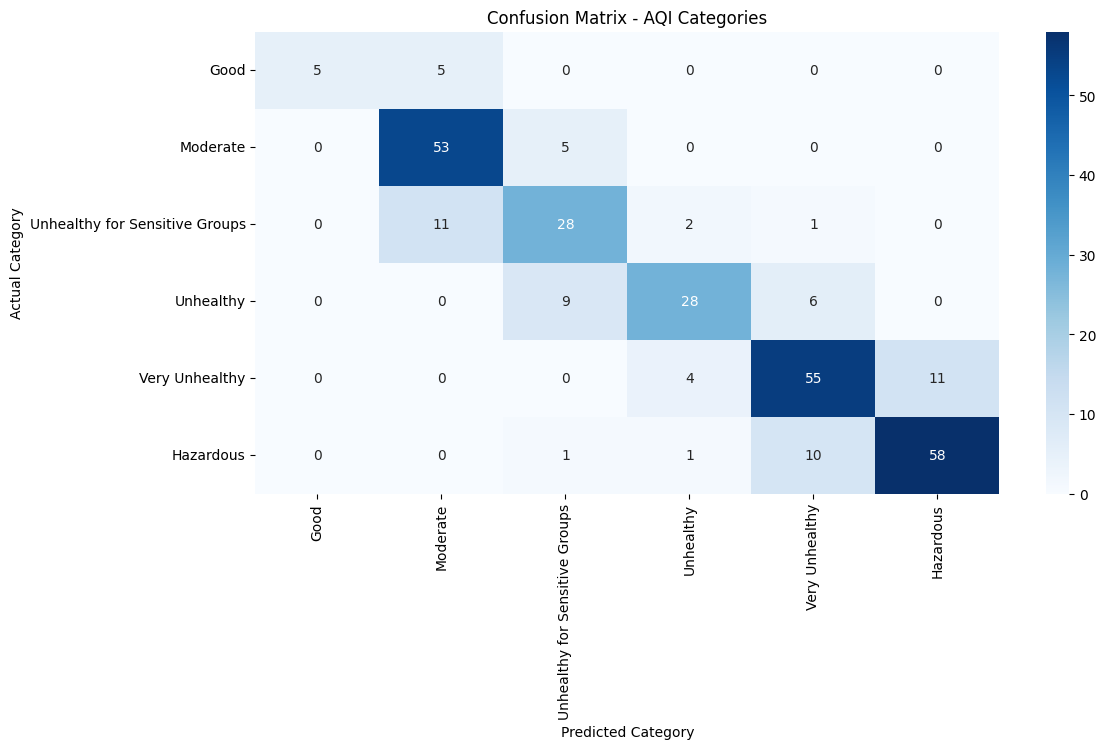


Classification Report:

                                precision    recall  f1-score   support

                          Good       1.00      0.50      0.67        10
                     Hazardous       0.84      0.83      0.83        70
                      Moderate       0.77      0.91      0.83        58
                     Unhealthy       0.80      0.65      0.72        43
Unhealthy for Sensitive Groups       0.65      0.67      0.66        42
                Very Unhealthy       0.76      0.79      0.77        70

                      accuracy                           0.77       293
                     macro avg       0.80      0.72      0.75       293
                  weighted avg       0.78      0.77      0.77       293


Predicted AQI: 454.80
Air Quality Level: Hazardous


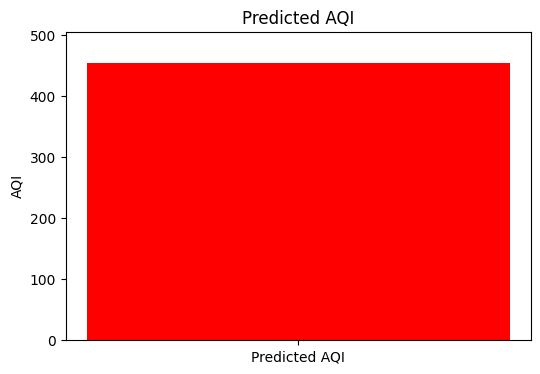

(454.8, 'Hazardous')

In [1]:
# ==============================================
# 1️⃣ Import Libraries
# ==============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# ==============================================
# 2️⃣ Load Dataset
# ==============================================
df = pd.read_csv("data.csv")
print("Dataset loaded successfully")
df.head()

# ==============================================
# 3️⃣ Convert Date Columns and Extract Features
# ==============================================
df_rename = df.rename(columns={'Date':'day','Month':'month','Year':'year'})
df_rename['Date_Combined'] = pd.to_datetime(df_rename[['year','month','day']])
df_rename['DayOfYear'] = df_rename['Date_Combined'].dt.dayofyear
df_rename['Month'] = df_rename['Date_Combined'].dt.month
df_rename['Year'] = df_rename['Date_Combined'].dt.year
print("Date columns converted successfully")
df_rename.head()

# ==============================================
# 4️⃣ Visualize Pollutant Trends
# ==============================================
plt.figure(figsize=(10,5))
plt.plot(df_rename['Date_Combined'], df_rename['PM2.5'], label='PM2.5', color='red')
plt.plot(df_rename['Date_Combined'], df_rename['PM10'], label='PM10', color='orange')
plt.plot(df_rename['Date_Combined'], df_rename['NO2'], label='NO2', color='green')
plt.xlabel("Date")
plt.ylabel("Pollutant Levels")
plt.title("Air Pollutants Over Time")
plt.legend()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_rename.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# ==============================================
# 5️⃣ Prepare Features and Target for ML
# ==============================================
features = ['Holidays_Count','Days','PM2.5','PM10','NO2','SO2','CO','Ozone','DayOfYear','Month','Year']
X = df_rename[features]
y = df_rename['AQI']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==============================================
# 6️⃣ Split Dataset into Train and Test
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ==============================================
# 7️⃣ Train Random Forest Regressor
# ==============================================
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
print("Training Score:", rf_model.score(X_train, y_train))
print("Test Score:", rf_model.score(X_test, y_test))

# ==============================================
# 8️⃣ Create AQI Categories for Classification
# ==============================================
def aqi_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi <= 200:
        return "Unhealthy"
    elif aqi <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

y_train_cat = y_train.apply(aqi_category)
y_test_cat = y_test.apply(aqi_category)

# Train Random Forest Classifier
clf_model = RandomForestClassifier(n_estimators=200, random_state=42)
clf_model.fit(X_train, y_train_cat)
y_pred_cat = clf_model.predict(X_test)

# ==============================================
# 9️⃣ Confusion Matrix
# ==============================================
labels = ["Good","Moderate","Unhealthy for Sensitive Groups","Unhealthy","Very Unhealthy","Hazardous"]
cm = confusion_matrix(y_test_cat, y_pred_cat, labels=labels)

plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix - AQI Categories")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test_cat, y_pred_cat))

# ==============================================
# 🔟 Function to Predict AQI from User Input
# ==============================================
def predict_aqi(user_input):
    df_input = pd.DataFrame([user_input])
    df_scaled = scaler.transform(df_input)
    predicted_aqi = rf_model.predict(df_scaled)[0]

    # Determine AQI Level
    level = aqi_category(predicted_aqi)
    print(f"\nPredicted AQI: {predicted_aqi:.2f}")
    print(f"Air Quality Level: {level}")

    # Plot AQI
    color = "green" if predicted_aqi <= 100 else "yellow" if predicted_aqi <=150 else "red"
    plt.figure(figsize=(6,4))
    plt.bar(['Predicted AQI'], [predicted_aqi], color=color)
    plt.ylim(0, max(500,predicted_aqi+50))
    plt.ylabel("AQI")
    plt.title("Predicted AQI")
    plt.show()

    return predicted_aqi, level

# ==============================================
# 1️⃣1️⃣ Example User Input
# ==============================================
example_input = {
    'Holidays_Count':0,
    'Days':5,
    'PM2.5':408.8,
    'PM10':442.42,
    'NO2':160.61,
    'SO2':12.95,
    'CO':2.77,
    'Ozone':43.19,
    'DayOfYear':1,
    'Month':1,
    'Year':2021
}

predict_aqi(example_input)


